In [1]:
from IPython.display import Image

스트리밍 시스템에서 일반적으로 실행하는 쿼리는 2가지 유형이 있다.  

- (1) **Ad-hoc query** : 스트림 데이터에서 쿼리를 1번만 수행할 때 사용된다. 최댓값을 뽑는다거나.. RDBMS 쿼리와 비슷하다  

- (2) **Continuous query** : 스트림 데이터에서 지속적으로 쿼리를 수행한다. 5분마다 최댓값을 표시한다거나, 임계치를 초과하면 경고문을 날린다거나...  

두 기능을 동일한 쿼리 언어로 제공하는 프레임워크는 아직 없다. SQL과 같은 쿼리를 제공하지 않는게 일반적이다. 프로그래밍 방식으로 코드를 짜야 한다. 

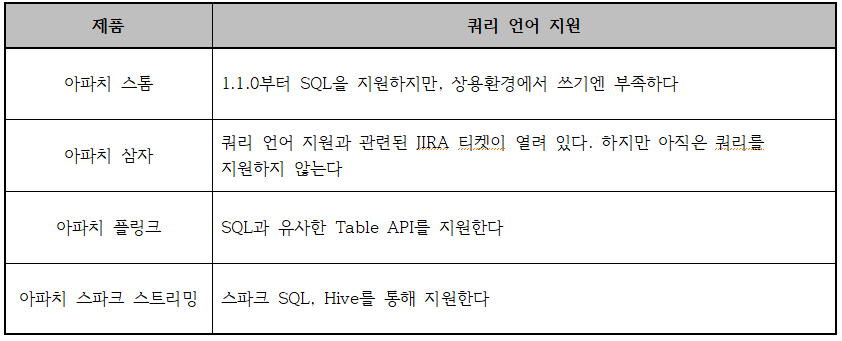

In [3]:
Image("C:/Users/jy990/Study/Streaming data/Image/5.1.PNG")

# 제약 조건 확인

스티리밍 시스템은 전체 스트림을 무제한으로 저장할 수 없다. 그리고 애플리케이션 프로세스가 종료되지 않고 쿼리를 계속 수행해야 한다. 이런 유형의 쿼리를 다루기 위해 몇 가지 조건을 고려해야 한다.  

- **한 번 호출(One-pass)** : 데이터가 보관되지 않기에 1번만 사용할 수 있다는 가정 하에 운영해야 한다. 즉, 마이닝 알고리즘을 여러 번 실행할 수 없다.  

- **개념 수정(Concept drift)** : 개념 수정이 예측 모델에 영향을 미칠 수 있다.  

- **리소스 제약(Resource constraints)** : 대부분 스트림 데이터는 처리 속도 제어가 안되는데, 서버 자원 한계로 인해 뒤늦게 도착하는 데이터를 삭제해야할 수도 있다. 이를 *Load shedding*이라 부른다.  

- **도메인 제약(Domain constraints)** : 특정 비즈니스 도메인에서, 믿기 힘든 대용량 데이터는 간단한 통계 작업 조차 정말 힘든 작업이 될 수 있다.  

이런 제약들 때문에 거의 모든 스트리밍 기술은 특정 형태의 시놉시스를 사용한다. 

# 시간

### Stream time vs Event time

스트림 시간은 이벤트가 스트리밍 시스템에 진입한 시점이고, 이벤트 시간은 이벤트가 실제로 발생한 시간이다. 이 둘은 항상 같지 않은데, 그 차이를 **Time skew**라고 부른다  

- **Time window** : 스트림 데이터는 크기와 종류가 무한해 기존의 배치 처리처럼 수행할 수 없다. 그래서 스트림 데이터에서 소량을 추출한 윈도우를 활용한다. 이때 모든 윈도우의 모든 데이터를 처리할 시간을 코드에 알려줘야 하고(Trigger), 윈도우 기간 데이터를 추출해 프로세싱 여부를 결정해야 한다(Eviction). 윈도우 내의 데이터 개수가 얼마인지 등에 따라 달라진다.  

- **Sliding window** : 윈도우에 포함된 데이터는 함께 처리되며, 윈도우 길이와 슬라이딩 간격을 설정해 처리한다. 즉 매 초마다 코드가 트리거되고, 트리거될 때마다 윈도우 간격의 모든 데이터를 처리한다. 스파크 스트리밍(스트림 시간만)과 플링크에서 지원한다. 스톰과 삼자는 구현은 가능한데, 지원을 안해줘서 효율적이지가 않다.  

- **Tumbling window** : 추출 조건은 윈도우 간격 내부의 데이터가 일정 개수만큼 포함된 상태, 트리거 조건은 윈도우 내부 데이터 수 또는 시간을 기준으로 한다. 따라서 카운트 기반 방식과 시간 기반 방식이 있다. 데이터가 몇 개 이상이면 추출하든가, 시간이 몇 초 이상이면 추출하든가. 플링크가 유일한 프레임워크다.

# 취합 기술

### 랜덤 샘플링

무작위로 샘플 데이터를 추출하고자 할 때 활용한다. 일반적으로 Reservoir Sampling을 활용하며, 새로운 값이 도착하면 수집으로 보낼지 아니면 이미 가지고 있던 데이터 중 하나를 랜덤 샘플 데이터로 정할지 고른다. 프레임워크에서 지원해주지는 않지만, 구현하는게 간단하다

### 데이터 개수 카운트

정확한 로그 개수를 세는 2가지 알고리즘이 있다.  

- (1) **비트 패턴 기반** : 각 스트림 데이터를 이진수로 변환하고, 앞부분 비트 패턴에 따라 처리한다. 스트림 데이터의 해시를 이진수로 나타내고 0으로 시작하는 데이터를 확인해 카디널리티를 결정하는 방식이다. LogLog, HyperLogLog, HyperLogLog++ 등이 있다.  

- (2) **순서 통계 기반** : 스트림 데이터 중 가장 작은 수를 찾는 것과 같다. MinCount, BarYossef가 있다.  

HperLogLog를 예로 들면, 광고 ID 문자열을 해시값으로 바꾼 뒤 해시값의 이진수를 가져와 업데이트 값을 결정한다. 사용하는 비트 수는 적당히 설정하며, 최하위에 있는 k개 비트를 십진수로 변환해 해당 배열을 업데이트한다. 그리고 모든 레지스터 값에 조화 평균을 취해 각 데이터별로 개수를 계산한다.

### 빈도

데이터 고유 개수가 아니라 X 데이터가 몇번 발생했는지는 어떻게 알 수 있을까? 이때 활용되는 알고리즘은 Count-min Sketch이다. 스트림 데이터의 개수 기반 집계 시 활용되며, 특정 스트림 데이터 값을 알고 싶으면 포인트 쿼리, 범위 내에서 빈도를 알고 싶으면 Range query, 그 외에 Ineer product query 등이 있다.  

이 알고리즘은 Counter라고 하는 숫자 배열 집합으로 구성되며, 각 카운터는 서로 다른 해시 함수와 연동 되어 있다.

### 멤버십

이 데이터가 아까 들어왔었는지 보고 싶을 때 모든 데이터를 확인할 필요는 없다. Bloom filter 데이터 구조를 사용하면 된다.